# This code represents an implementation of the Spectral Clustering algorithm  without using libraries that would give us the clusters directly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

In [2]:
#This cell is for Lloyds Algorithm
def cluster_index( U, Y ):
    
    #Get the distance matrix which measures euclidean distance between rows of U and Y
    distanceMatrix = euclidean_distances( U, Y )
    
    #Return the index of the column that has minimun value as this would identify the closest centroid
    #and the average distance
    return ( np.argmin( distanceMatrix, axis=1 ), np.mean( np.amin( distanceMatrix, axis=1 ) ) )

def lloyds_kmean( U, k, tol ):
    
    #Convert U to pandas dataframe 
    U = pd.DataFrame( U )
    
    #Initialization
    Y = U.sample( k )    #samples k points from df uniformly and stores them into Y
    Y.index  = list( range( len( Y.index ) ) )    #Replacing index values with regular 0,1,2,3,..,k-1
    
    #Initializing D to have very large value and D_ to have value less than D - tolerance to allow looping
    D = 1e5
    D_ = D - (tol + 7)
    
    while D - D_ > tol:
        D = D_
        #Assigning cluster index to each row of U and getting average distance
        C, D_ = cluster_index( U, Y )

        #Update Y with new centroids by calculating means of clusters
        for i in Y.index:
            Y.loc[i] = U.loc[U.index[C == i]].mean()
            
    #Return Y, C and D_
    return( Y, C, D_ )

In [3]:
#This function returns a matrix with Gaussian similarity between rows of dataframe
def gaussian_similarity_matrix( df ):
    
    #Ask the user for a sigma value
    sigma = float( input( "Please input a value for sigma:\nRemember that the parameter sigma controls the width of the neighborhoods" ) )
    
    #Create Euclidean distance matrix
    distance_Matrix = euclidean_distances( df, df )
    
    #Modify distance matrix to represent Gaussian similarity matrix
    distance_Matrix = np.exp( -np.square(distance_Matrix) / ( 2 * np.square(sigma) ) )
    
    #Return the gaussian-similarity matrix
    return distance_Matrix

#This function returns a matrix where each row has binary values and 1 representing that the row has that row as its nearest neighbor
def k_Nearest_Neighbor_matrix( df ):
    
    #Ask the user to input a value for k
    k = int( input( "Please input a value for k") )
    
    #Create a numpy array of zeros of size no. of rows in df x no. of rows in df
    k_NN_structure = np.zeros((df.shape[0],df.shape[0]))
    
    #Fill in 1 at all k nearest neighbors of each row
    k_NN_structure[np.array([np.arange(df.shape[0])]).T,\
                   np.array(list(map( lambda x: np.argsort(euclidean_distances( x, df ))[:,1:k+1][0], np.array(df) )))] = 1
    
    #Ask the user what kind of undirected k-Nearest Neighbor structure does he/she want
    structure_type = input("What kind of undirected structure do you desire?\n" \
                           + "Press M for 'Mutual Nearest Neighbor Graph' which means that " \
                           + "vertices vi and vj are connected if both vi is among the k-nearest" \
                           + "neighbors of vj and vj is among the k-nearest neighbors of vi\n" \
                           + "Press S to simply ignore the directions of the edges, that is " \
                           + "connect vi and vj with an undirected edge if vi is among" \
                           + "the k-nearest neighbors of vj or if vj is among the k-nearest neighbors of vi.")
    
    if structure_type == 'M':
        k_NN_structure = k_NN_structure * k_NN_structure.T
    elif structure_type =='S':
        k_NN_structure[k_NN_structure + k_NN_structure.T > 0] = 1 
    
    #Return the k-Nearest Neighbor structure matrix
    return k_NN_structure
    
            

In [4]:
def adjacency_matrix_creation( df ):
    
    #Get the k Nearest Neighbor Structure
    k_nearest_neighbor_structure = k_Nearest_Neighbor_matrix( df )
    
    #Get the Gaussian Similarity matrix
    gaussian_similarity = gaussian_similarity_matrix( df )
    
    #Multiply the two together to get the Weighted adjacency matrix W
    W = k_nearest_neighbor_structure * gaussian_similarity
    
    #Return the Weighted adjacency matrix W
    return W   
    

In [5]:
#This function performs un-normalized graph Laplacian Spectral Clustering
def spectral_clustering( path, k ):
    
    #Read the data
    df = pd.read_csv( path, header = None )
    
    #W = adjacency matrix
    W = adjacency_matrix_creation( df )

    #Get the degree matrix D
    D = np.diag( np.sum( W, axis = 1 ) )
    
    #Get the graph Laplacian matrix
    L = D - W
    
    #Get the eigen values and eigen vectors of L
    w, v = np.linalg.eig( L )
    
    #Sort the eigen vectors based on ascending order of the eigen values
    v = v[ : , np.argsort( w ) ]
    
    #Ask the user to input a value of K which would help us get the first K eigen vectors
    K = int(input( "Please input a value for K to select the first K eigen vectors: "))
    
    #Store the first K eigen vectors in U
    print(v.shape)
    U = v[:,:K]
    
    #Ask the user to input a value for tolerance for Lloyds Algorithm
    tol = float(input( "Please input a value for tolerance for Lloyds Algorithm" ))
    
    #Run the Lloyds k-Means algorithm to return centers, cluster index vector and the objective function cost
    return lloyds_kmean( U, k, tol )

In [6]:
centers, Cluster_index, cost = spectral_clustering( "clustering.csv", 2 )

Please input a value for k15
What kind of undirected structure do you desire?
Press M for 'Mutual Nearest Neighbor Graph' which means that vertices vi and vj are connected if both vi is among the k-nearestneighbors of vj and vj is among the k-nearest neighbors of vi
Press S to simply ignore the directions of the edges, that is connect vi and vj with an undirected edge if vi is amongthe k-nearest neighbors of vj or if vj is among the k-nearest neighbors of vi.M
Please input a value for sigma:
Remember that the parameter sigma controls the width of the neighborhoods0.894427191
Please input a value for K to select the first K eigen vectors: 2
(2000, 2000)
Please input a value for tolerance for Lloyds Algorithm1e-5


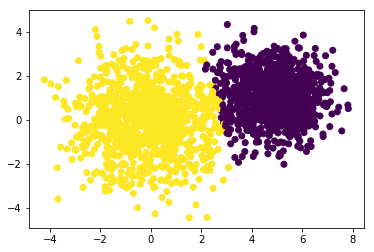

In [7]:
trial_df = pd.read_csv("clustering.csv", header=None)
plt.scatter(trial_df[0], trial_df[1], c=Cluster_index)
plt.show()

In [10]:
centers, Cluster_index, cost = spectral_clustering( "ShapedData.csv", 4 )

Please input a value for k9
What kind of undirected structure do you desire?
Press M for 'Mutual Nearest Neighbor Graph' which means that vertices vi and vj are connected if both vi is among the k-nearestneighbors of vj and vj is among the k-nearest neighbors of vi
Press S to simply ignore the directions of the edges, that is connect vi and vj with an undirected edge if vi is amongthe k-nearest neighbors of vj or if vj is among the k-nearest neighbors of vi.M
Please input a value for sigma:
Remember that the parameter sigma controls the width of the neighborhoods0.65
Please input a value for K to select the first K eigen vectors: 2
(4460, 4460)
Please input a value for tolerance for Lloyds Algorithm1e-5


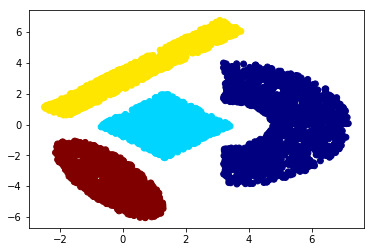

In [11]:
trial_df = pd.read_csv("ShapedData.csv", header=None)
norm = plt.Normalize()
plt.scatter(trial_df[0], trial_df[1],  c = plt.cm.jet(norm(Cluster_index)))
plt.show()